In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from math import sqrt
from sklearn.metrics import mean_squared_error

2024-03-07 22:29:15.164848: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 22:29:15.199193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 22:29:15.199215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 22:29:15.200080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 22:29:15.205369: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 22:29:15.206176: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
start_date = '2023-05-01'
end_date = '2024-03-08'
symbol='AMZN'

In [3]:
stock_data = pd.DataFrame()

In [4]:
stock = yf.Ticker(symbol)
data = stock.history(start=start_date, end=end_date)
stock_data = pd.concat([stock_data, pd.DataFrame(data)], ignore_index=False)

In [5]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-01 00:00:00-04:00,104.949997,105.230003,101.820000,102.050003,74728100,0.0,0.0
2023-05-02 00:00:00-04:00,101.470001,103.900002,101.150002,103.629997,73469400,0.0,0.0
2023-05-03 00:00:00-04:00,103.739998,105.959999,103.279999,103.650002,65051900,0.0,0.0
2023-05-04 00:00:00-04:00,104.040001,105.389999,103.309998,104.000000,45345500,0.0,0.0
2023-05-05 00:00:00-04:00,104.269997,105.760002,103.550003,105.660004,56912900,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-01 00:00:00-05:00,176.750000,178.729996,176.070007,178.220001,31956200,0.0,0.0
2024-03-04 00:00:00-05:00,177.529999,180.139999,177.490005,177.580002,37381500,0.0,0.0
2024-03-05 00:00:00-05:00,176.929993,176.929993,173.300003,174.119995,37228300,0.0,0.0


In [6]:
stock_data['sma'] = stock_data['Close'].rolling(window=20).mean()
stock_data["ema"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
delta = stock_data["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data["rsi"] = 100 - (100 / (1 + rs))
# Moving Average Convergence Divergence (MACD)
#def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
short_ema = stock_data["ema"]
long_ema = stock_data["Close"].ewm(span=16, adjust=False).mean()
macd_line = short_ema - long_ema
signal_line = macd_line.ewm(span=9, adjust=False).mean()
stock_data["macd"] = macd_line - signal_line
# Bollinger Bands
sma = stock_data["Close"].rolling(window=20).mean()
std = stock_data["Close"].rolling(window=20).std()
stock_data["bolinger_upper"] = sma + (std * 2)
stock_data["bolinger_lower"] = sma - (std * 2)

In [7]:
columns_to_drop = ['Open', 'macd', 'Dividends', 'Stock Splits']
stock_data = stock_data.drop(columns=columns_to_drop)
stock_data = stock_data.dropna()

In [8]:
stock_data

,High,Low,Close,Volume,sma,ema,rsi,bolinger_upper,bolinger_lower
Date,,,,,,,,,
2023-05-26 00:00:00-04:00,121.500000,116.019997,120.110001,96779900,111.021501,114.515899,75.554756,122.102517,99.940485
2023-05-30 00:00:00-04:00,122.919998,119.860001,121.660004,64314800,112.002001,115.614992,76.202088,123.210172,100.793830
2023-05-31 00:00:00-04:00,122.040001,119.169998,120.580002,72800800,112.849501,116.378840,69.820673,123.955083,101.743919
2023-06-01 00:00:00-04:00,123.489998,119.930000,122.769997,54375100,113.805501,117.362095,70.049214,124.868412,102.742590
2023-06-02 00:00:00-04:00,126.389999,124.019997,124.250000,61215000,114.818001,118.421773,76.934912,125.808711,103.827291
...,...,...,...,...,...,...,...,...,...
2024-03-01 00:00:00-05:00,178.729996,176.070007,178.220001,31956200,171.950498,173.225568,57.020495,177.954489,165.946508
2024-03-04 00:00:00-05:00,180.139999,177.490005,177.580002,37381500,172.238998,173.895481,60.323104,178.747850,165.730147
2024-03-05 00:00:00-05:00,176.929993,173.300003,174.119995,37228300,172.429498,173.930022,60.898958,178.923638,165.935359


In [9]:
model = load_model("/home/ayarkhan01/Desktop/Projects/model_name.keras")

In [10]:
final_observations = pd.DataFrame()

for i in range(60, len(stock_data)):
    # Get the current date at position i
    current_date = stock_data.index[i]
    
    # Get the start date for the 60-day window
    start_date = stock_data.index[i - 59]
    
    # Select the data from the last 60 days
    last_60_days = stock_data.loc[start_date:current_date]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)
    last_60_days_scaled = scaler.transform(last_60_days)
# Reshape this data to match the LSTM model's input shape
    X_last_60_days = last_60_days_scaled.reshape((1, 60, stock_data.shape[1]))
# Predict the scaled close price for the next day
    predicted_close_scaled = model.predict(X_last_60_days)
# Prepare a composite array for inverse transformation
    composite_array = np.zeros((1, stock_data.shape[1]))
    close_idx = stock_data.columns.get_loc("Close")  # Replace "Close" with the exact column name as in your DataFrame

# Insert the predicted scaled 'close' price into the composite array
    composite_array[0, close_idx] = predicted_close_scaled[0, 0]

# Inversely transform the composite array to get the original scale of data
    predicted_close_unscaled = scaler.inverse_transform(composite_array)[0, close_idx]
    print(stock_data.index[i])
    print(f"Predicted next day's close price: {predicted_close_unscaled}")
    
    new_row = pd.DataFrame([predicted_close_unscaled], columns=['predicted_close'])

# Concatenate vertically (assuming that's your intent)
    final_observations = pd.concat([final_observations, new_row], ignore_index=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2023-08-23 00:00:00-04:00
Predicted next day's close price: 135.78895466204722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2023-08-24 00:00:00-04:00
Predicted next day's close price: 134.5140388323598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2023-08-25 00:00:00-04:00
Predicted next day's close price: 134.05220878996283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2023-08-28 00:00:00-04:00
Predicted next day's close price: 134.16615479862935
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2023-08-29 00:00:00-04:00
Predicted next day's close price: 135.15545750277397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2023-08-30 00:00:00-04:00
Predicted next day's close price: 135.75841349607958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2023-08-31 00:00:00-04:00
Predicted next day's close price: 137.44549785568915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2023-09-01 00:00:00-04:00
Predicted next day's close price: 138.47218303087766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2023-09-05 00:00:00-04:00


2023-09-07 00:00:00-04:00
Predicted next day's close price: 137.68451354841955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2023-09-08 00:00:00-04:00
Predicted next day's close price: 138.3639614151914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2023-09-11 00:00:00-04:00
Predicted next day's close price: 140.97068567521183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2023-09-12 00:00:00-04:00
Predicted next day's close price: 141.84350441080983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2023-09-13 00:00:00-04:00
Predicted next day's close price: 143.64671441818405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2023-09-14 00:00:00-04:00
Predicted next day's close price: 145.19382294919978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2023-09-15 00:00:00-04:00
Predicted next day's close price: 143.34055640253746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2023-09-18 00:00:00-04:00
Predicted next day's close price: 141.62053100167418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2023-09-19 00:00:00-04:00
Predicted next day's close price: 139.3

In [11]:
final_observations.shape

(136, 1)

In [12]:
a = stock_data.index[len(stock_data)-1]
    
# Get the start date for the 60-day window
b = stock_data.index[60]

# Select the data from the last 60 days
c = stock_data.loc[b:a]

In [13]:
# Reset the index of c to be numerical
c = c.reset_index()


In [14]:
final_observations["actual"] = c["Close"]

In [15]:
final_observations

,predicted_close,actual
0,135.788955,135.520004
1,134.514039,131.839996
2,134.052209,133.259995
3,134.166155,133.139999
4,135.155458,134.910004
...,...,...
131,175.121334,178.220001
132,175.890874,177.580002
133,172.690563,174.119995
134,171.961193,173.509995


In [16]:
final_observations['actual'] = final_observations['actual'].shift(-1)

# Set the last row of 'actual' to NaN
final_observations.at[len(final_observations) - 1, 'actual'] = np.nan

In [17]:
final_observations

,predicted_close,actual
0,135.788955,131.839996
1,134.514039,133.259995
2,134.052209,133.139999
3,134.166155,134.910004
4,135.155458,135.070007
...,...,...
131,175.121334,177.580002
132,175.890874,174.119995
133,172.690563,173.509995
134,171.961193,176.820007


In [18]:
filename = symbol + '_data.csv'  # Concatenate to form the filename

# Save the DataFrame to CSV
final_observations.to_csv(filename, index=False)

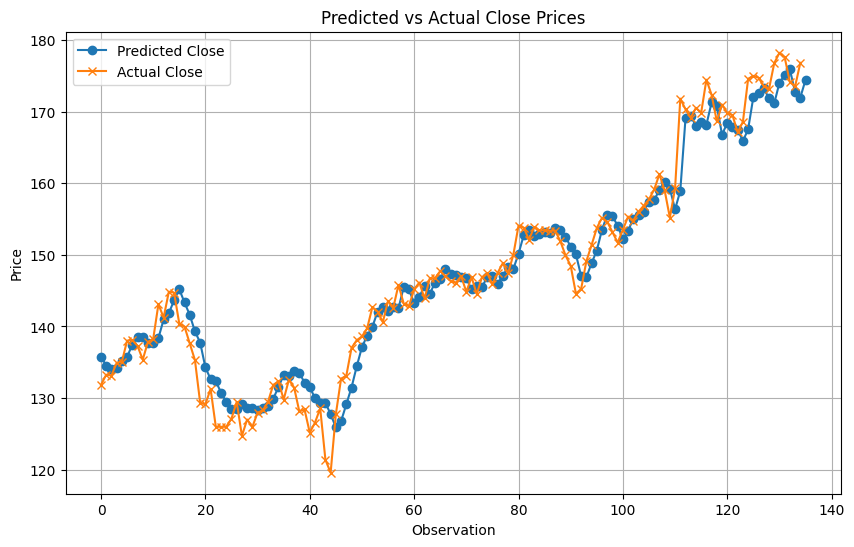

In [19]:
import matplotlib.pyplot as plt

# Assuming final_observations is your DataFrame
# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(final_observations.index, final_observations['predicted_close'], label='Predicted Close', marker='o')
plt.plot(final_observations.index, final_observations['actual'], label='Actual Close', marker='x')

# Adding plot title and labels
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Observation')
plt.ylabel('Price')
plt.legend()  # Add a legend to distinguish between lines

# Show the plot
plt.grid(True)  # Add grid for better readability
plt.show()
